In [1]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.quantum_info import state_fidelity, Statevector

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_textbook.tools import vector2latex
%matplotlib inline

import laspaclu.quantum.dist_calc as dica

In [2]:
def normalize(v):
    return v / np.linalg.norm(v)

In [3]:
def calc_z(a, b):
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    return a_mag**2 + b_mag**2

In [4]:
def psi_amp(a, b):
    
    a_norm = normalize(a)
    b_norm = normalize(b)
    
    return np.hstack([a_norm, b_norm]) * (1/np.sqrt(2))    

In [5]:
def phi_amp(a, b):
    
    z = calc_z(a, b)
    a_mag =  np.linalg.norm(a)
    b_mag =  np.linalg.norm(b)
    
    return np.hstack([a_mag, -b_mag])/np.sqrt(z)

In [6]:
def psi_circuit(a, b):

    amp = psi_amp(a, b) # 2*n amplitudes 1/sqrt(2) (a0, ..., an, b0, ..., bn)
    sz = int(np.log2(len(amp)))
    
    qc = QuantumCircuit(sz) # 2 qubits if a,b in R^2

    qc.initialize(amp, range(sz))
    
    return qc

In [7]:
def phi_circuit(a, b):
    
    amp = phi_amp(a, b) # 4 amplitudes 1/sqrt(2) (a0, a1, b0, b1)
    sz = 1
    
    qc = QuantumCircuit(sz) # 2 qubits if a,b in R^2

    qc.initialize(amp, [0])
    
    return qc

In [8]:
def dot_product_circuit(a, b, state=False):
    
    n = len(a)
    if not ((n & (n-1) == 0) and n != 0):
        raise ValueError("size of input vectors must be power of 2 but is " + str(n))
    
    psi = psi_circuit(a, b)
    phi = phi_circuit(a, b)
    
    anc = QuantumRegister(1, 'ancilla')
    qr_psi = QuantumRegister(psi.width(), 'psi')
    qr_phi = QuantumRegister(phi.width(), 'phi')
    cr = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(anc, qr_psi, qr_phi, cr)
    
    qc.append(psi, qr_psi[:])
    qc.append(phi, qr_phi[:])
    
    qc.barrier()
    
    qc.h(0)
    qc.cswap(0, qr_psi[-1], qr_phi[0]) # perform test on psi ancilla alone
    qc.h(0)
    
    if state == False:
        qc.measure(0,0)
    
    return qc

In [9]:
def run_circuit(qc):
    simulator = Aer.get_backend('qasm_simulator')
    return execute(qc, backend=simulator, shots=1000).result().get_counts(qc)

In [10]:
def calc_overlap(answer, state='0'):
    shots = answer[state] if len(answer) == 1 else answer['0']+answer['1']
    #return 1 - np.abs(counts[state]/1000 - 0.5)*2
    return np.abs(answer[state]/1000 - 0.5)*2

In [11]:
def calc_dist(answer, z, state='0'):
    return calc_overlap(answer, state)*2*z

In [12]:
psi_amp([1,1],[1,-1])

array([ 0.5,  0.5,  0.5, -0.5])

In [13]:
v = [0.3,0.9]
w = [0.1,1.2]

qc = psi_circuit(v, w)
state_vec = Statevector.from_instruction(qc).data

vector2latex(state_vec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [14]:
qc.width() # number of qubit and classic registers

2

In [15]:
qc.draw()

┌───────────────────────────────────────────────┐
q_0: ┤0                                              ├
     │  Initialize(0.22361,0.67082,0.058722,0.70466) │
q_1: ┤1                                              ├
     └───────────────────────────────────────────────┘

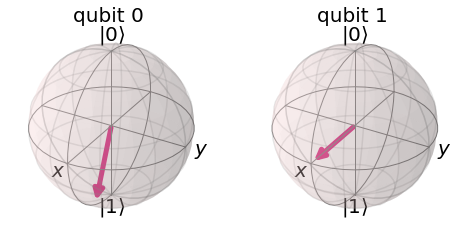

In [16]:
plot_bloch_multivector(state_vec)

In [17]:
qc = dot_product_circuit(v, w, state=True)

In [18]:
state_vec = Statevector.from_instruction(qc).data
vector2latex(state_vec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

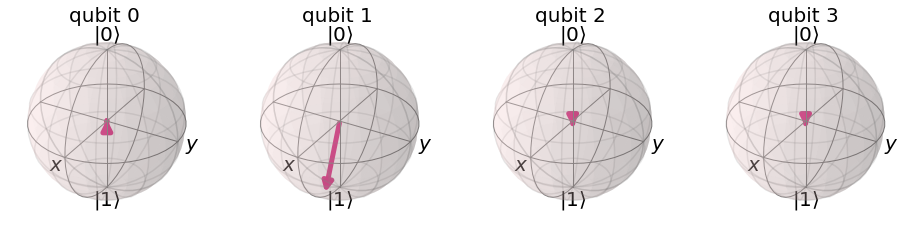

In [19]:
plot_bloch_multivector(state_vec)

In [20]:
qc.draw()

░ ┌───┐   ┌───┐
ancilla: ────────────────░─┤ H ├─■─┤ H ├
         ┌─────────────┐ ░ └───┘ │ └───┘
  psi_0: ┤0            ├─░───────┼──────
         │  circuit-24 │ ░       │      
  psi_1: ┤1            ├─░───────X──────
         └┬────────────┤ ░       │      
    phi: ─┤ circuit-25 ├─░───────X──────
          └────────────┘ ░              
    c: 1/═══════════════════════════════

In [21]:
v = [0.3,0.9]
w = [0.1,1.2]
qc = dot_product_circuit(v, w)

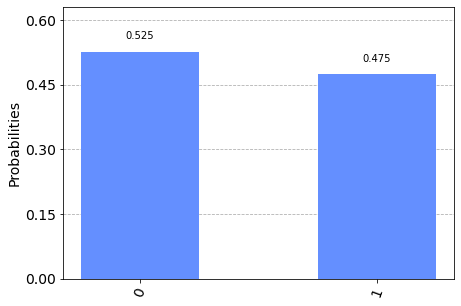

In [22]:
counts = run_circuit(qc)
plot_histogram(counts)

In [23]:
calc_overlap(counts)

0.050000000000000044

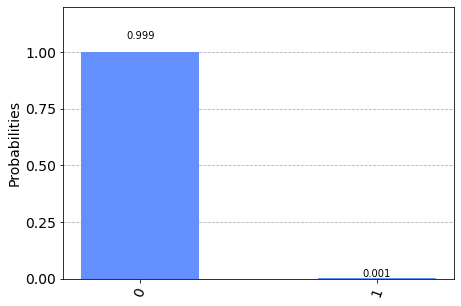

In [24]:
v = [0.3,0.9]
w = [-0.3,-1.0]
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [25]:
calc_overlap(counts)

0.998

In [26]:
np.dot(v,w)

-0.99

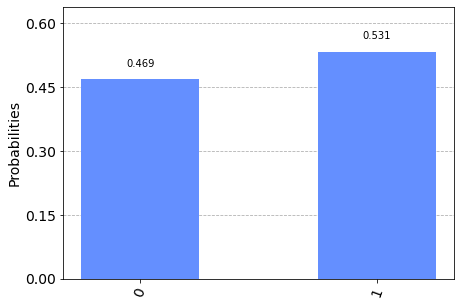

In [27]:
v = [0.3,0.9]
w = [0.3,0.9]
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [28]:
calc_overlap(counts)

0.062000000000000055

In [29]:
np.dot(v,w)

0.9

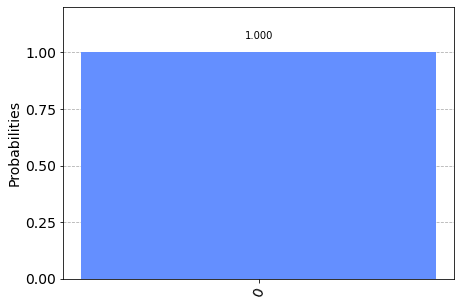

In [30]:
v = np.array([0.3,0.9])
w = np.array([-0.3,-0.9])
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [31]:
calc_overlap(counts)

1.0

In [32]:
np.linalg.norm(v-w)

1.8973665961010275

In [33]:
np.dot(v,w)

-0.9

## < a | a >

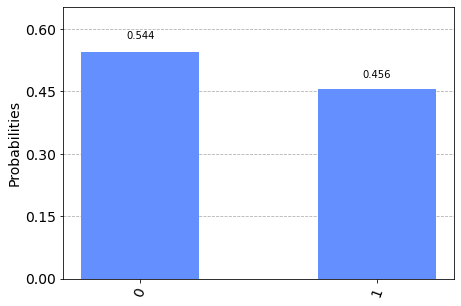

In [34]:
v = np.array([1,1])
qc = dot_product_circuit(v, v)
counts = run_circuit(qc)
plot_histogram(counts)

In [35]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,v)))
print('eucl dist: ', np.linalg.norm(v-v))

overlap:  0.08800000000000008
q-dist:  0.7040000000000007
eucl dist:  0.0


## < a | -a >

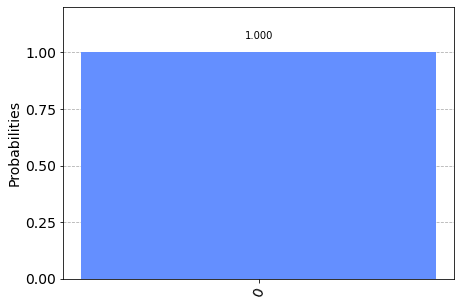

In [36]:
qc = dot_product_circuit(v, -v)
counts = run_circuit(qc)
plot_histogram(counts)

In [37]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,-v)))
print('eucl dist: ', np.linalg.norm(v+v))

overlap:  1.0
q-dist:  8.000000000000002
eucl dist:  2.8284271247461903


## < a | -2 a >

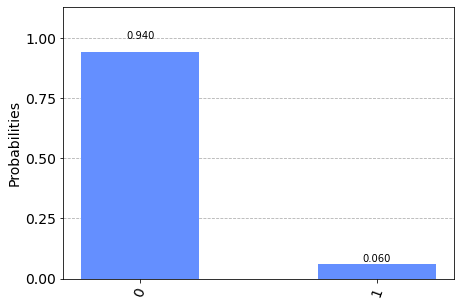

In [38]:
qc = dot_product_circuit(v, -2*v)
counts = run_circuit(qc)
plot_histogram(counts)

In [39]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,-2*v)))
print('eucl dist: ', np.linalg.norm(v+2*v))

overlap:  0.8799999999999999
q-dist:  17.6
eucl dist:  4.242640687119285


In [4]:
# calculate overlaps for different input vectors
dists_q = []
dists_eucl = []
overlaps = []
vectors = []
sz = 8
min_val = -1
max_val = 1
v = np.random.uniform(low=min_val, high=max_val, size=sz)
for i in range(int(5e4)):
        w = np.random.uniform(low=min_val, high=max_val, size=sz)
        # calc quantum dist 
        qc = dica.overlap_circuit(v,w)#dot_product_circuit(v, w)
        counts = dica.run_circuit(qc)
        overlaps.append(dica.calc_overlap(counts))
        dists_q.append(dica.calc_dist(counts, dica.calc_z(v, w)))
        # calc euclidian dist
        dists_eucl.append(np.linalg.norm(v-w))
        vectors.append((v,w))

Text(0, 0.5, 'quantum distance')

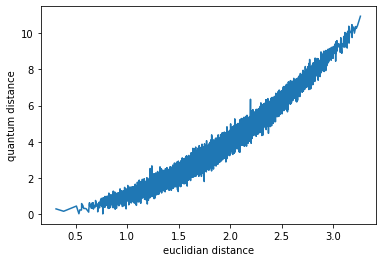

In [5]:
# plot results
d_eucl_srtd, d_q_srtd, overlaps_srtd, vectors_srtd = zip(*sorted(zip(dists_eucl, dists_q, overlaps, vectors)))
plt.plot(d_eucl_srtd, d_q_srtd)
# plt.hist2D
# profile plot: mean +/- err
# matplotlib.hep tprofile
plt.xlabel('euclidian distance')
plt.ylabel('quantum distance')

<ErrorbarContainer object of 3 artists>

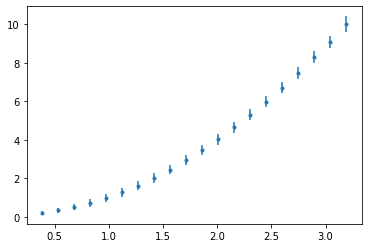

In [6]:
import scipy.stats
x = np.array(d_eucl_srtd)
y = np.array(d_q_srtd)
means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=20, range=(d_eucl_srtd[0],d_eucl_srtd[-1]), statistic='mean')
means, means2 = means_result.statistic
standard_deviations = np.sqrt(means2 - means**2)
bin_edges = means_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.

plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, linestyle='none', marker='.')

In [43]:
k1 = np.array([ 1.1717812 ,  0.8324707 , -1.5320506 , -1.819728  , -0.24345303,
        0.3065474 ,  1.1804538 ,  0.17510843])

In [44]:
s = np.array([ 0.0671954 ,  0.19998848, -1.0702754 , -0.49416354, -0.12478945,
        0.52299917, -0.19559914, -0.11996016])

In [45]:
qc = dot_product_circuit(s, k1)

In [46]:
counts = run_circuit(qc)

In [47]:
calc_dist(counts, calc_z(s, k1))

5.095875472065005

In [48]:
np.linalg.norm(s-k1)

2.37318785635897

In [49]:
counts

{'1': 385, '0': 615}